SAE实现MNIST或FashionMNIST

In [ ]:
#加载相应包
!pip install memory_profiler
%load_ext memory_profiler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(0)
np.random.seed(0)

#超参数设置
num_epoch = 10
batch_size = 64
lr = 0.005
N_TEST_IMG = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#下载数据
train_data = datasets.FashionMNIST(
  root = "data",
  train = True,
  transform = transforms.ToTensor(),
  download = True,
)
test_data = datasets.FashionMNIST(
  root = "data",
  train = False,
  transform = transforms.ToTensor(),
  download = True,
)
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15880685.85it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 276017.96it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4982558.85it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19176089.69it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class SparseAutoencoder(nn.Module):
    def __init__(self, rho=0.05, beta=0.1):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
        self.rho = rho  # Desired sparsity
        self.beta = beta  # Sparsity penalty coefficient

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def kl_divergence(self, rho, rho_hat):
        rho_hat = torch.clamp(rho_hat, 1e-12, 1-1e-12)
        return torch.sum(rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat)))

    def compute_loss(self, decoded, x):
        mse_loss = F.mse_loss(decoded, x)
        rho_hat = torch.mean(F.sigmoid(self.encoder(x)), dim=0)  # Calculate mean activation using sigmoid to ensure values between 0 and 1
        kl_loss = self.beta * self.kl_divergence(self.rho, rho_hat)
        return mse_loss + kl_loss

model = SparseAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
#训练
%%memit
model.train()
for epoch in range(num_epoch):
    for step, (images, _) in enumerate(train_loader):
        images = images.to(device).view(-1, 28*28)
        optimizer.zero_grad()
        _, decoded = model(images)
        loss = model.compute_loss(decoded, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss: 0.0317
Epoch [2/10], Loss: 0.0311
Epoch [3/10], Loss: 0.0293
Epoch [4/10], Loss: 0.0288
Epoch [5/10], Loss: 0.0280
Epoch [6/10], Loss: 0.0333
Epoch [7/10], Loss: 0.0253
Epoch [8/10], Loss: 0.0253
Epoch [9/10], Loss: 0.0357
Epoch [10/10], Loss: 0.0312
peak memory: 1060.08 MiB, increment: 288.24 MiB


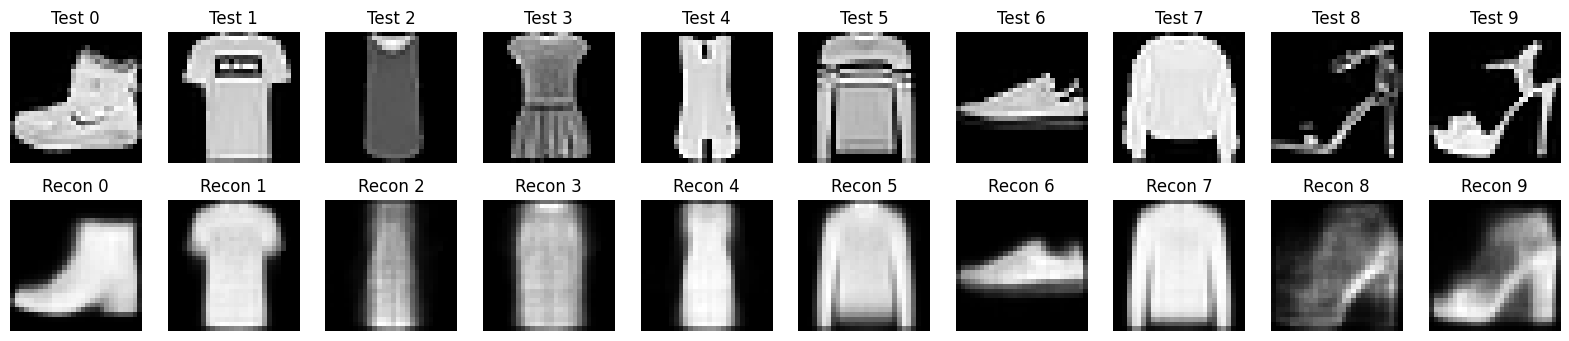

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4))  # 2 行 10 列

for i in range(10):
    test_data = (train_data.data[i].view(-1, 28*28).type(torch.FloatTensor)/255).to(device)
    _, result = model(test_data)
    result = result.view(28, 28).detach().cpu().numpy()


    axs[0, i].imshow(train_data.data[i].cpu().numpy(), cmap='gray')
    axs[0, i].set_title('Test {}'.format(i))
    axs[0, i].axis('off')

    axs[1, i].imshow(result, cmap='gray')
    axs[1, i].set_title('Recon {}'.format(i))
    axs[1, i].axis('off')

plt.show()